In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.special import expit, logit  # inv.logit is expit in Python; logit is its inverse function
from scipy.stats import norm, t as student_t
import statsmodels.api as sm
import re

# 2008 election

## Collect Data

In [3]:
# DOWNLOAD 2008 DATA

# Create the data folder if it doesn't exist
import os
os.makedirs('data', exist_ok=True)

# Define the URLs for the raw CSV files on GitHub
files = {
    'data/all_polls_2008.csv': 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/all_polls_2008.csv',
    'data/2008.csv': 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/2008.csv',
    'data/potus_results_76_16.csv': 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/potus_results_76_16.csv',
    'data/2008.csv': 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/2008.csv',
}

# Download each file and save it to the corresponding local path
import requests

for local_path, url in files.items():
    print(f"Downloading {url} to {local_path}")
    response = requests.get(url)
    response.raise_for_status()  # check for errors
    with open(local_path, 'wb') as f:
        f.write(response.content)
print("Downloads completed!")


Downloads completed!


## Set Master Variables for 2008 election

In [4]:
RUN_DATE = pd.to_datetime("2008-11-03")
election_day = pd.to_datetime("2008-11-03")
start_date = election_day - pd.DateOffset(months=6)  # keep polls from the last 6 months

## Data Processing:

For the 2008 poll data
1. Select relevant columns from poll csv file
2. Rename columns, poll names, and dates.
3. Calculate the vote share for each poll
4. Convert all categories into numerical indices so they can be passed into Stan

* The time for the poll is the midpoint between the start and end dates of the poll

* obama, mccain, other, and undecided columns are percentages not exact counts

* Calculated T is the time from the first poll to election day

In [5]:
# ----------------------- Wrangle Polls Data -----------------------
# Read the polls CSV file
all_polls = pd.read_csv('data/all_polls_2008.csv')

df = all_polls.copy().rename(columns={'number.of.observations': 'n'})
df['begin'] = pd.to_datetime(df['start.date'])
df['end'] = pd.to_datetime(df['end.date'])

# Make sure all polls are before simulation run day
df = df[df['end'] <= RUN_DATE]

# Compute the t of the poll as the middle date of the poll
# t = end date minus half of the poll duration (using integer division)
df['t'] = df.apply(lambda row: row['end'] - pd.Timedelta(days=(1 + (row['end'] - row['begin']).days) // 2), axis=1)

# Filter rows: ensure t is on/after the start_date, n > 1, and not NA
df = df[(df['t'] >= start_date) & (df['t'].notna()) & (df['n'] > 1)]

# Replace missing values in 'undecided' and 'other' with 0
df['undecided'] = df['undecided'].fillna(0)
df['other'] = df['other'].fillna(0)

/var/folders/15/mymz4pp57vl23l_yjdgq0xvh0000gn/T/ipykernel_37476/467533733.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['begin'] = pd.to_datetime(df['start.date'])
/var/folders/15/mymz4pp57vl23l_yjdgq0xvh0000gn/T/ipykernel_37476/467533733.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end'] = pd.to_datetime(df['end.date'])


In [6]:
# ----------------------- Clean and Standardize Pollster Names -----------------------
# Use regex to extract only letters, digits, and spaces then trim trailing spaces
df['pollster'] = df['pollster'].str.extract(r'([A-Za-z0-9 ]+)', expand=False).str.rstrip()

# Fix pollster name inconsistencies
df['pollster'] = df['pollster'].replace({
    "Fox News": "FOX",
    "WashPost": "Washington Post",
    "ABC News": "ABC"
})

# Count number of polls by each pollster
poll_counts = df['pollster'].value_counts()

# Sum sample sizes per pollster
sample_sizes = df.groupby('pollster')['n'].sum().sort_values(ascending=False)

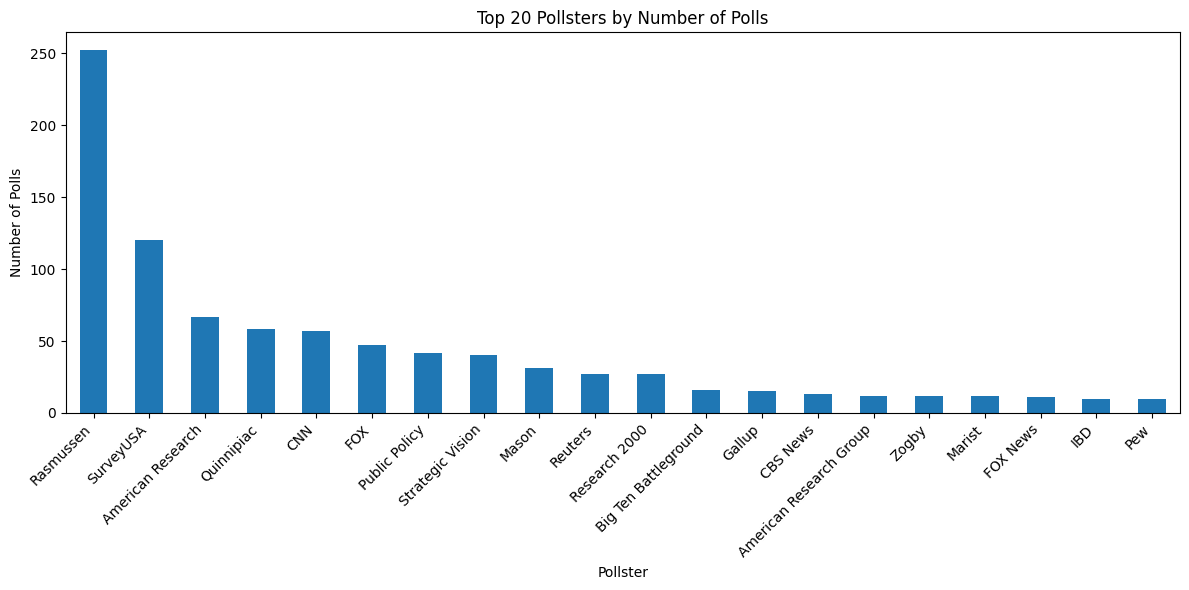

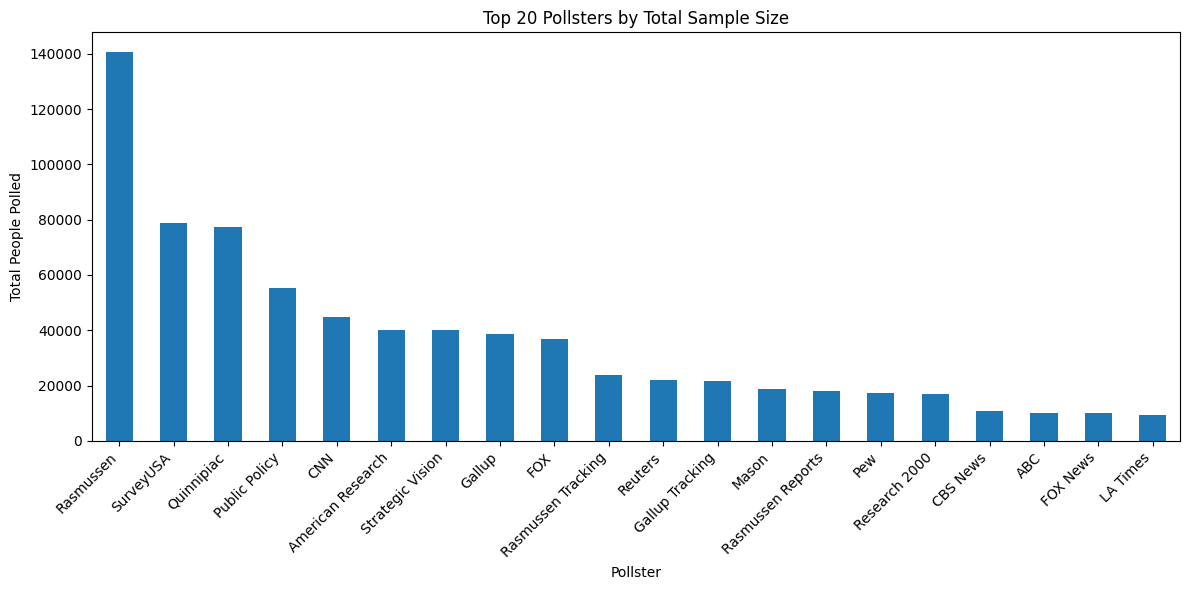

In [7]:
# Plot the top polls by frequency
plt.figure(figsize=(12, 6))
poll_counts.head(20).plot(kind='bar')  # limit to top 20 for readability
plt.title('Top 20 Pollsters by Number of Polls')
plt.xlabel('Pollster')
plt.ylabel('Number of Polls')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the top boys by number of people sampled
plt.figure(figsize=(12, 6))
sample_sizes.head(20).plot(kind='bar')
plt.title('Top 20 Pollsters by Total Sample Size')
plt.xlabel('Pollster')
plt.ylabel('Total People Polled')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# ----------------------- Compute Vote Shares and Related Variables -----------------------
df['obama'] = df['obama'].astype(int)
df['mccain'] = df['mccain'].astype(int)

df['two_party_sum'] = df['obama'] + df['mccain']

# Map the 'population' variable to numeric poll type codes:
# "Likely Voters" -> 0, "Registered Voters" -> 1, "Adults" -> 2
polltype_mapping = {"Likely Voters": 0, "Registered Voters": 1, "Adults": 2}
df['polltype'] = df['population'].map(polltype_mapping)

df['n_round'] = df['n'].round() # in case n is not an int already

# Calculate counts and percentages for Obama, McCain, and third-party (other) votes
df['n_obama'] = (df['n'] * df['obama'] / 100).round()
df['pct_obama'] = df['obama'] / df['two_party_sum']

df['n_mccain'] = (df['n'] * df['mccain'] / 100).round()
df['pct_mccain'] = df['mccain'] / df['two_party_sum']

df['n_other'] = (df['n'] * df['other'] / 100).round()
df['pct_other'] = df['other'] / 100

In [9]:
# ----------------------- Create Numerical Indices -----------------------
# We need numerical indices to

# Get the list of all states
unique_states = list(df.sort_values(by='state')['state'].unique())
state_mapping = {}
for i in range(len(unique_states)):
  # add 1 since R is 1 indexed
  state_mapping[unique_states[i]] = i+1

# Compute the poll day index: difference from the earliest midpoint plus one day
min_t = df['t'].min()
df['poll_day'] = (df['t'] - min_t).dt.days + 1

df['index_s'] = df['state'].apply(lambda s: state_mapping[s])
df['index_t'] = (1 + (df['t'] - min_t).dt.days).astype('int') # same as poll_day
df['index_p'] = df['pollster'].astype('category').cat.codes + 1 #sets a code for each pollster

In [10]:
# ----------------------- Further Selections -----------------------

# Compute total days from the earliest poll beginning to election day (T)
min_begin = df['begin'].min()
T = (election_day - min_begin).days

# Sort data by s, t, type, sum and remove duplicate polls based on state, t, and pollster
df = df.sort_values(by=['state', 't', 'polltype', 'two_party_sum'])
df = df.drop_duplicates(subset=['state', 't', 'pollster'])

# # small renaming thing
# df = df[['state', 't', 'begin', 'end', 'pollster', 'polltype', 'mode', 'n_respondents',
#          'pct_obama', 'n_obama', 'pct_mccain', 'n_mccain', 'p_other', 'n_other',
#          'poll_day', 'index_s', 'index_p', 'index_t']]
# df = df.rename(columns={'mode': 'method'})

## Pull prior information:

5. Pull state information / vote weights
6. Set priors

* Change ev to evotes, i thought it was expected value not electoral votes.

In [11]:
# ----------------------- Useful Vectors for Further Computations -----------------------
# Sorted list of unique polled states
all_polled_states = np.sort(df['state'].unique())

# Create day indices: first day, number of days, list of all days, and days until election
first_day = df['begin'].min()
ndays = (df['t'].max() - df['t'].min()).days
all_t = [df['t'].min() + timedelta(days=i) for i in range(ndays + 1)]
all_t_until_election = [all_t[0] + timedelta(days=i) for i in range((election_day - all_t[0]).days + 1)]

# pkremp code also includes week indices, but don't think these are necessary pre-model

# List of unique pollsters
all_pollsters = df['pollster'].unique()

How do they set the prior on the state-level and national level for $\beta_{iJ} \sim N(logit(h_i), s^2_i)$.

It's lowkey complicated in the paper versus in practice. Will implement both methods below:

1. **Lizner**: use structural "Time-for-Change" model ([Abramowitz (2008)](https://www.jstor.org/stable/20452296?seq=2)) to predict historical forecasts. Use an early and late forecast (10 weeks prior to election day) depending on the timing of the poll. Set prior variance $\frac{1}{\sigma^2} = \tau_i$ = 10 or 20 depending on timing of poll.

In [12]:
# ----------------------- Linzner model prior -----------------------
## A lot of these are hard coded with information from the paper

# Grab 2004 state-level results
potus_results_76_16 = pd.read_csv('data/potus_results_76_16.csv')
state_results_2004 = potus_results_76_16[potus_results_76_16['year'] == 2004].reset_index(drop=True)

# Calculate counts for each candidate and difference in % compared to national score
state_results_2004['kerr_count'] = state_results_2004['total_votes']*state_results_2004['dem']
state_results_2004['bush_count'] = state_results_2004['total_votes']*state_results_2004['rep']
state_results_2004['score'] = state_results_2004['kerr_count'] / (state_results_2004['kerr_count'] + state_results_2004['bush_count'])
national_score_2004 = state_results_2004['kerr_count'].sum()/(state_results_2004['kerr_count'] + state_results_2004['bush_count']).sum()
state_results_2004['delta'] = state_results_2004['score'] - national_score_2004
state_results_2004['share_national_vote'] = state_results_2004['total_votes'] / state_results_2004['total_votes'].sum()
state_results_2004 = state_results_2004.sort_values(by='state') # sort to make sure indices match

# Set the prior value for h_i (Linzner paper)
# 0.488 is the structural model prediction cited in 20
state_results_2004['h_prior'] = 0.488 + state_results_2004['delta']

# # Linzner correction
# # Add/subtract 6% in winning candidate home states (Holbrook, Campbbell, Lock and Gelman)

# # Obama, McCain are from Hawaii and Arizona
# state_results_2004.loc[state_results_2004['state'].isin(['HI', 'AR']), 'dem'] += 0.06
# state_results_2004.loc[state_results_2004['state'].isin(['HI', 'AR']), 'rep'] -= 0.06

# # Bush, Kerry are from Texas, Mass.
# state_results_2004.loc[state_results_2004['state'].isin(['TX', 'MA']), 'rep'] += 0.06
# state_results_2004.loc[state_results_2004['state'].isin(['TX', 'MA']), 'dem'] -= 0.06

# Lock and Gelman correction
# Add the 6% correction to every home state

# Dem candidates are from Illinois (Obama) and Mass (Kerry)
state_results_2004.loc[state_results_2004['state'].isin(['IL', 'MA']), 'h_prior'] += 0.06
state_results_2004.loc[state_results_2004['state'].isin(['TX', 'AR']), 'h_prior'] -= 0.06

# Given that the forecast is LATE (We are using all the polls), we add an additional 5.5%
state_results_2004['h_prior'] += 0.055

# We set the logit as our mu_prior_b
mu_prior_b_linzner = logit(state_results_2004['h_prior'])

# Since our forecast is LATE, we set the variance to 1/20
var_prior_b_linzner = [0.05 for i in range(len(mu_prior_b_linzner))]

## Creating Linzner Stan Model

In [13]:
# !pip install cmdstanpy
# !python -m cmdstanpy.install_cmdstan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 2.9 MB/s eta 0:00:00
/Users/maxtan/miniconda3/envs/pres_bayes/lib/python3.10/runpy.py:126: RuntimeWarning: 'cmdstanpy.install_cmdstan' found in sys.modules after import of package 'cmdstanpy', but prior to execution of 'cmdstanpy.install_cmdstan'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
CmdStan install directory: /Users/maxtan/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /var/folders/15/mymz4pp57vl23l_yjdgq0xvh0000gn/T/tmp2dpnghbs
Extracting distribution
Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.
Installed cmdstan-2.36.0
Test model compilation


In [ ]:
from cmdstanpy import CmdStanModel
import os

# Ignore this -- todo: port stan code from the github (more complicated than the linzer model)
# Rewrite the provided Stan code with anchored delta[J] using transformed parameters

stan_code = """
data {
  int<lower=1> K;                    // number of polls
  int<lower=1> J;                    // number of campaign days
  int<lower=1> S;                    // number of states
  array[K] int<lower=1, upper=S> state; // state for each poll
  array[K] int<lower=1, upper=J> day;   // day for each poll
  array[K] int<lower=0> n;               // sample size of poll
  array[K] int<lower=0> y;               // number of dem supporters
  vector[S] h;                        // historical forecasts (h_i)
  vector[S] tau;                      // prior precision for each state (tau_i)
}
parameters {
  matrix[S, J] beta;                 // state-level support over time
  vector[J - 1] delta_raw;           // free parameters for national swing (J-1 values)
  real<lower=0, upper=1> sigma_beta;          // variance of beta
  real<lower=0, upper=1> sigma_delta;         // variance of delta
}
transformed parameters {
  vector[J] delta;
  for (j in 1:(J - 1))
    delta[j] = delta_raw[j];
  delta[J] = 0;  // anchor on Election Day
}
model {
  // Priors on beta and delta (reverse random walk from election day J)
  for (s in 1:S)
    beta[s, J] ~ normal(logit(h[s]), inv(sqrt(tau[s])));

  for (j in 1:(J - 1)) {
    for (s in 1:S)
      beta[s, j] ~ normal(beta[s, j + 1], sigma_beta);
    delta_raw[j] ~ normal(delta[j + 1], sigma_delta);
  }

  // Likelihood: poll observations
  for (k in 1:K) {
    real logit_pi = beta[state[k], day[k]] + delta[day[k]];
    y[k] ~ binomial_logit(n[k], logit_pi);
  }

  // Hyperpriors
  sigma_beta ~ uniform(0, 1);
  sigma_delta ~ uniform(0, 1);
}
generated quantities {
  matrix[S, J] pi;
  for (s in 1:S)
    for (j in 1:J)
      pi[s, j] = inv_logit(beta[s, j] + delta[j]);
}
"""

# For local
local_dir = 'model/'
os.makedirs('model', exist_ok=True)

# # For colab
# model_path = "/content/drive/MyDrive/poll_model.stan"

model_name = 'linzner_2008_model.stan'
model_path = local_dir + model_name

with open(model_path, "w") as f:
    f.write(stan_code)

model = CmdStanModel(stan_file=model_path)

/Users/maxtan/miniconda3/envs/pres_bayes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
19:05:26 - cmdstanpy - INFO - compiling stan file /Users/maxtan/Documents/MIT/Spring_2025/bayesian_modeling/project/code/model/linzner_2008_model.stan to exe file /Users/maxtan/Documents/MIT/Spring_2025/bayesian_modeling/project/code/model/linzner_2008_model
19:05:34 - cmdstanpy - INFO - compiled model executable: /Users/maxtan/Documents/MIT/Spring_2025/bayesian_modeling/project/code/model/linzner_2008_model


## Test Linzner Stan model on 2008 data

### Run Stan Model

In [25]:
# Test on actual data

from scipy.special import logit

# State mapping
linzner_poll_data = df[df['state'] != '--']
state_mapping = {state: i + 1 for i, state in enumerate(linzner_poll_data['state'].unique())}
linzner_poll_data['index_s'] = linzner_poll_data['state'].map(state_mapping)
linzner_poll_data['index_t'] = (linzner_poll_data['t'] - df['t'].min()).dt.days + 1

# Get values for Stan model
K = len(linzner_poll_data)
S = len(state_mapping) # get rid of national values
J = linzner_poll_data['index_t'].max()

# Prior (mean = logit of adjusted 2004 vote share, variance = 1/20)

# # Dem VPs are from Delaware (Biden) and North Carolina (John Edwards)
# state_results_2004.loc[state_results_2004['state'].isin(['DE', 'NC']), 'h_prior'] += 0.06
# # Rep VPs are from Delaware (Sarah Palin) and Wyoming (Dick Cheney)
# state_results_2004.loc[state_results_2004['state'].isin(['AK', 'WY']), 'h_prior'] -= 0.06

state_results_2004 = state_results_2004.sort_values(by="state")

h = state_results_2004['h_prior'].values
# Since the forecast is late
tau = np.repeat(20.0, S)  # Precision = 1 / 0.05

# Create Stan input dictionary
stan_data = {
    "K": K,
    "S": S,
    "J": J,
    "state": linzner_poll_data["index_s"].astype(int).tolist(),
    "day": linzner_poll_data["index_t"].astype(int).tolist(),
    ## should probably n the number of people who wanted to vote for mccain OR obama (just the two major parties) rather than including all people polled
    "n": (linzner_poll_data["n_obama"] + linzner_poll_data["n_mccain"]).astype(int).tolist(),
    "y": linzner_poll_data["n_obama"].astype(int).tolist(),
    "h": h.tolist(),
    "tau": tau.tolist(),
}

print(K, J)


872 183


/var/folders/15/mymz4pp57vl23l_yjdgq0xvh0000gn/T/ipykernel_5771/639542357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linzner_poll_data['index_s'] = linzner_poll_data['state'].map(state_mapping)
/var/folders/15/mymz4pp57vl23l_yjdgq0xvh0000gn/T/ipykernel_5771/639542357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linzner_poll_data['index_t'] = (linzner_poll_data['t'] - df['t'].min()).dt.days + 1


In [ ]:
# Save all the output CSV files from each chain
fit = model.sample(data=stan_data, chains=4, iter_sampling=500, iter_warmup=500)
description = "linzner_2008_model"

# local
os.makedirs('stan_output/', exist_ok = True)

fit.save_csvfiles(dir=f"stan_output/{description}/")
summary_df = fit.summary()
summary_df.to_csv(f"stan_output/{description}/fit_summary.csv")

# # colab
# fit.save_csvfiles(dir=f"/content/drive/MyDrive/bayesian project/stan_output/{description}/")
# summary_df = fit.summary()
# summary_df.to_csv(f"/content/drive/MyDrive/bayesian project/stan_output/{description}/fit_summary.csv")

19:06:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 01:02 Iteration:   1 / 1000 [  0%]  (Warmup)





chain 1 |██▌       | 01:56 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 03:04 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 04:02 Iteration: 300 / 1000 [ 30%]  (Warmup)





chain 1 |█████▊    | 05:03 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 06:11 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 07:14 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 08:23 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 09:24 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 11:06 Sampling completed                      
chain 2 |██████████| 11:06 Sampling completed                      
chain 3 |██████████| 11:06 Sampling completed                      
chain 4 |██████████| 11:06 Sampling completed                      


19:17:54 - cmdstanpy - INFO - CmdStan done processing.


19:17:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 500 iterations at max treedepth (100.0%)
	Chain 2 had 500 iterations at max treedepth (100.0%)
	Chain 3 had 500 iterations at max treedepth (100.0%)
	Chain 4 had 500 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


AttributeError: module 'os' has no attribute 'makedir'

### Plot Results

#### Time-Series Plots

Plotting for Florida (FL)
Plot for FL saved to FL_election_forecast_plot.png


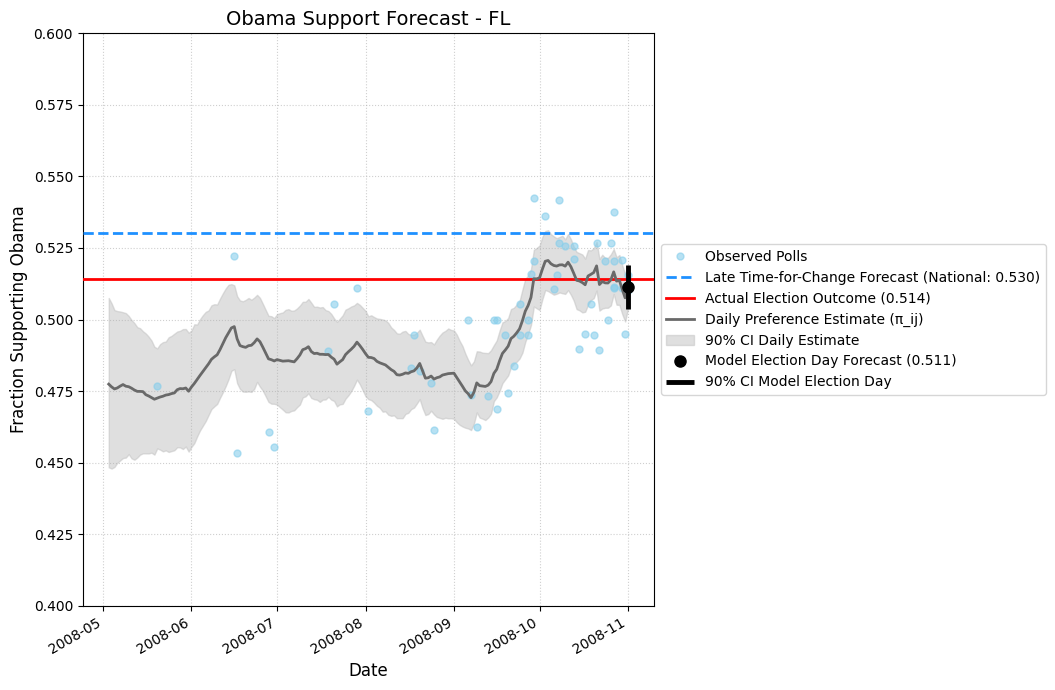

\nPlotting for Indiana (IN)
Plot for IN saved to IN_election_forecast_plot.png


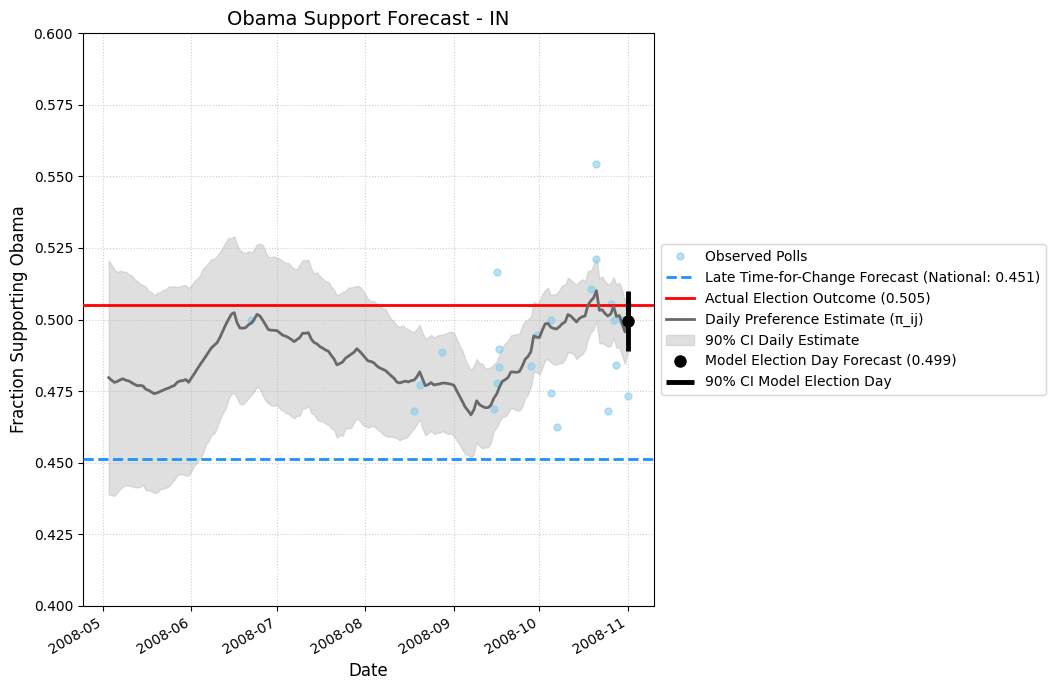

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logit # Used in notebook cell 15
from plot_helpers import plot_state_election_forecast_from_notebook_data

# It's assumed that 'fit' (CmdStanMCMC object), 'state_mapping',
# 'all_polls_df_S', 'day_objects_linzner', and 'election_day'
# are already defined and populated from previous cells in your notebook.
# If not, you'll need to run those cells first.

# For example, these would typically be loaded from your notebook's execution state:
# election_day = pd.to_datetime("2008-11-03") # From cell 3
# start_date = pd.to_datetime("2008-03-01") # From cell 3
# state_mapping = {'AL': 0, 'AK': 1, ..., 'WY': 49} # From cell 12
# S = len(state_mapping)
# J = (election_day - start_date).days + 1 # Number of days in the model period
day_objects_linzner = pd.to_datetime([start_date + pd.Timedelta(days=i) for i in range(J)]) # From cell 13 for model_linzner_stan


# --- Example of how you would call this in your notebook ---
# Ensure all these variables are defined from your notebook's cells:
# fit, state_mapping, all_polls_df_S, day_objects_linzner, election_day

print("Plotting for Florida (FL)")
plot_state_election_forecast_from_notebook_data(
    state_abbr='FL', 
    fit_model=fit,  # This should be your actual CmdStanMCMC object
    loaded_state_mapping=state_mapping, 
    polls_df=linzner_poll_data, 
    model_dates_array=day_objects_linzner, 
    current_election_day=election_day
)

print("\\nPlotting for Indiana (IN)")
plot_state_election_forecast_from_notebook_data(
    state_abbr='IN', 
    fit_model=fit, 
    loaded_state_mapping=state_mapping, 
    polls_df=linzner_poll_data, 
    model_dates_array=day_objects_linzner, 
    current_election_day=election_day
)

# print("Plotting function using notebook data defined.")
# print("To use, uncomment the example calls above and ensure prerequisite variables are loaded from your notebook.")

Plot saved to delta_trend_plot.png


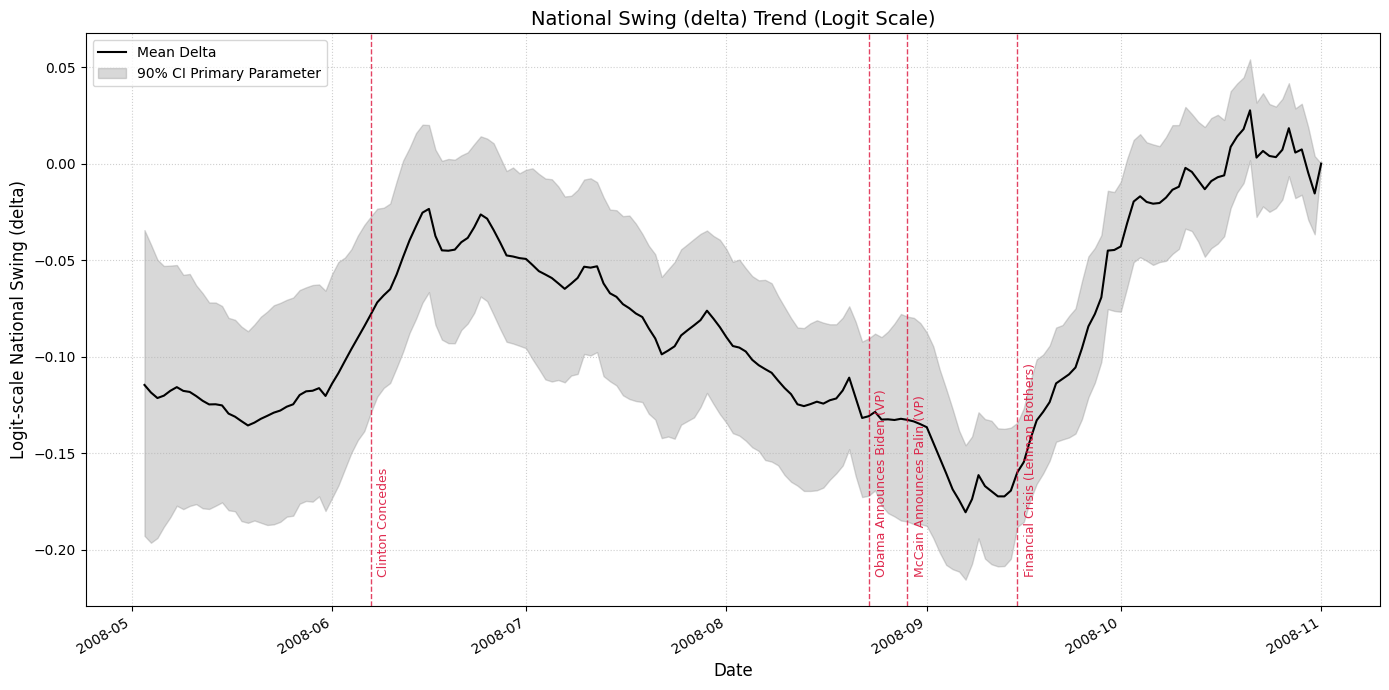

Plot saved to beta_FL_with_delta_overlay_trend_plot.png


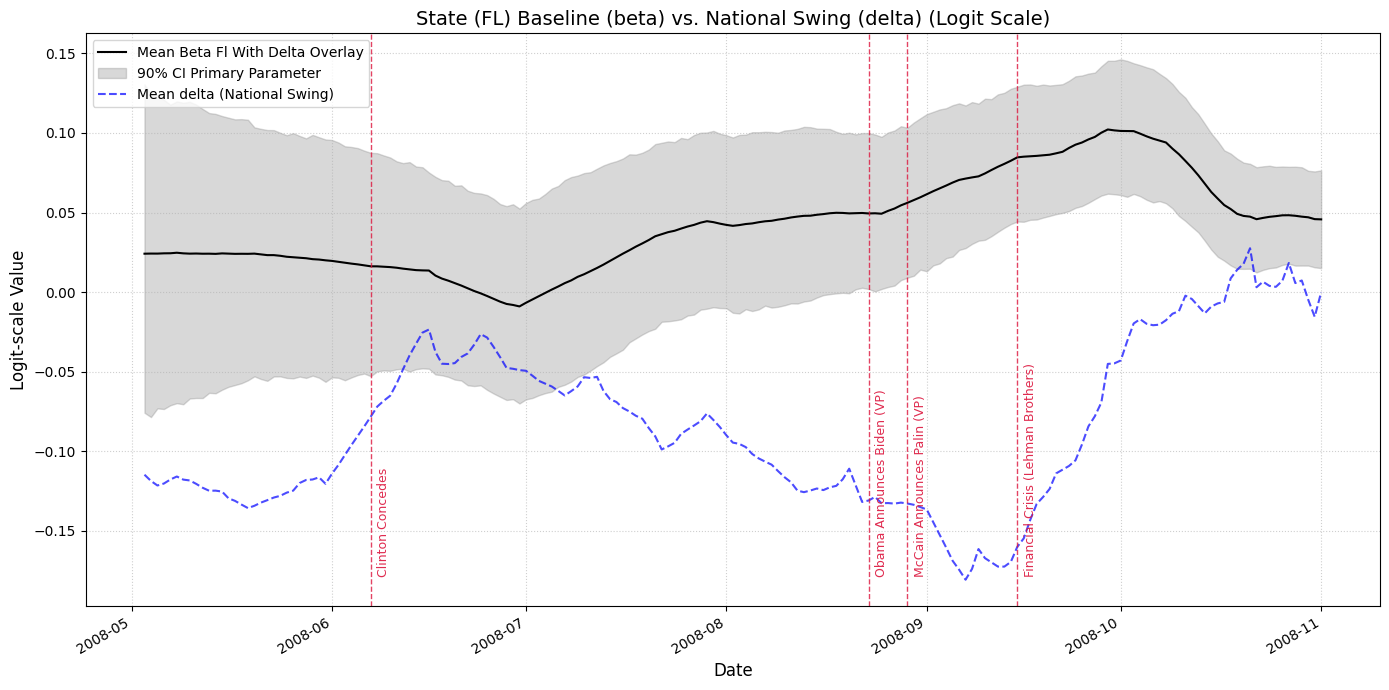

Plot saved to beta_IN_with_delta_overlay_trend_plot.png


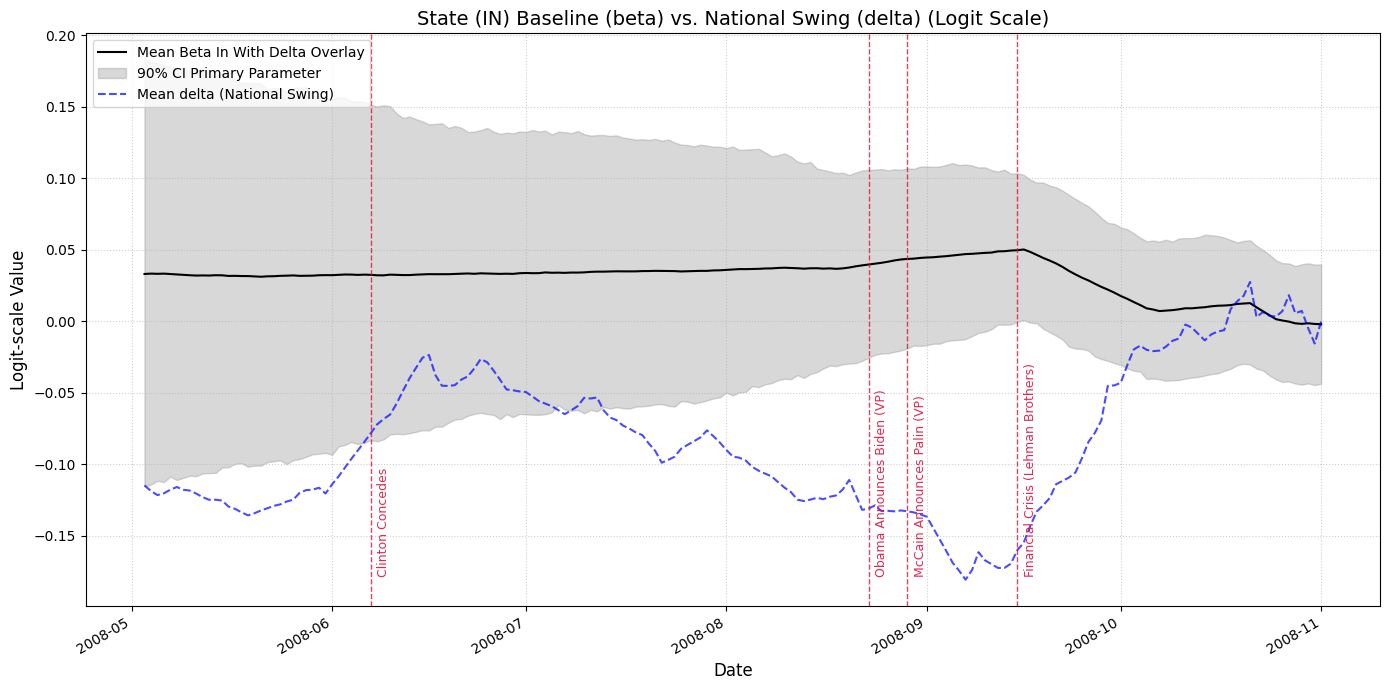

Parameter trend plotting script finished.


In [37]:
# --- Start of new cell code for plotting beta (with delta overlay) and delta ---
# (Ensure 'fit', 'day_objects_linzner', 'J', and 'state_mapping'
# are defined from previous cells in your notebook.)

from plot_helpers import plot_parameter_trends

# 1. Define Important Dates
important_dates_2008 = {
    "Clinton Concedes": pd.to_datetime("2008-06-07"),
    "Obama Announces Biden (VP)": pd.to_datetime("2008-08-23"),
    "McCain Announces Palin (VP)": pd.to_datetime("2008-08-29"),
    "Financial Crisis (Lehman Brothers)": pd.to_datetime("2008-09-15"),
    "Election Day": pd.to_datetime("2008-11-04") # Assuming this is your election day
}

# 3. Extract parameters and Generate Plots

if 'fit' not in locals() and 'fit' not in globals():
    print("Error: 'fit' object not found. Please run the Stan model fitting cell first.")
else:
    try:
        delta_samples = fit.stan_variable("delta") # Shape: (draws, J-1)
        beta_samples = fit.stan_variable("beta")           # Shape: (draws, S, J)
    except Exception as e:
        print(f"Error extracting Stan variables: {e}")
        delta_samples = None
        beta_samples = None

    if 'day_objects_linzner' in locals() and 'J' in locals() and J > 1:
        dates_for_delta = pd.to_datetime(day_objects_linzner)[:J]
        dates_for_beta = pd.to_datetime(day_objects_linzner)[:J]

        # Plot for delta (National Swing) - NO OVERLAY HERE
        if delta_samples is not None:
            plot_parameter_trends(
                parameter_samples=delta_samples,
                dates_array=dates_for_delta,
                dates_dict=important_dates_2008,
                title="National Swing (delta) Trend (Logit Scale)",
                y_label="Logit-scale National Swing (delta)",
                param_name="delta"
            )
        else:
            print("Skipping delta plot as samples are not available.")

        # Plots for beta (State-level baseline) WITH delta OVERLAY
        if beta_samples is not None and 'state_mapping' in locals():
            example_states = ['FL', 'IN'] 
            for state_abbr in example_states:
                if state_abbr in state_mapping:
                    state_idx_for_beta = state_mapping[state_abbr] - 1 
                    
                    if 0 <= state_idx_for_beta < beta_samples.shape[1]:
                        beta_state_samples = beta_samples[:, state_idx_for_beta, :]
                        plot_parameter_trends(
                            parameter_samples=beta_state_samples,
                            dates_array=dates_for_beta, # Dates for beta
                            dates_dict=important_dates_2008,
                            title=f"State ({state_abbr}) Baseline (beta) vs. National Swing (delta) (Logit Scale)",
                            y_label=f"Logit-scale Value",
                            param_name=f"beta_{state_abbr}_with_delta_overlay",
                            overlay_param_samples=delta_samples, # Pass delta samples for overlay
                            overlay_dates_array=dates_for_delta, # Pass dates for delta
                            overlay_param_label='Mean delta (National Swing)' # Label for the overlay
                        )
                    else:
                        print(f"State index {state_idx_for_beta} for {state_abbr} is out of bounds for beta samples.")
                else:
                    print(f"State abbreviation {state_abbr} not found in state_mapping.")
        else:
            print("Skipping beta plots as samples or state_mapping are not available, or delta samples needed for overlay are missing.")
    else:
        print("Error: 'day_objects_linzner' or 'J' not defined. Cannot determine dates for plots.")

print("Parameter trend plotting script finished.")
# --- End of new cell code ---

#### Election Day Outcomes

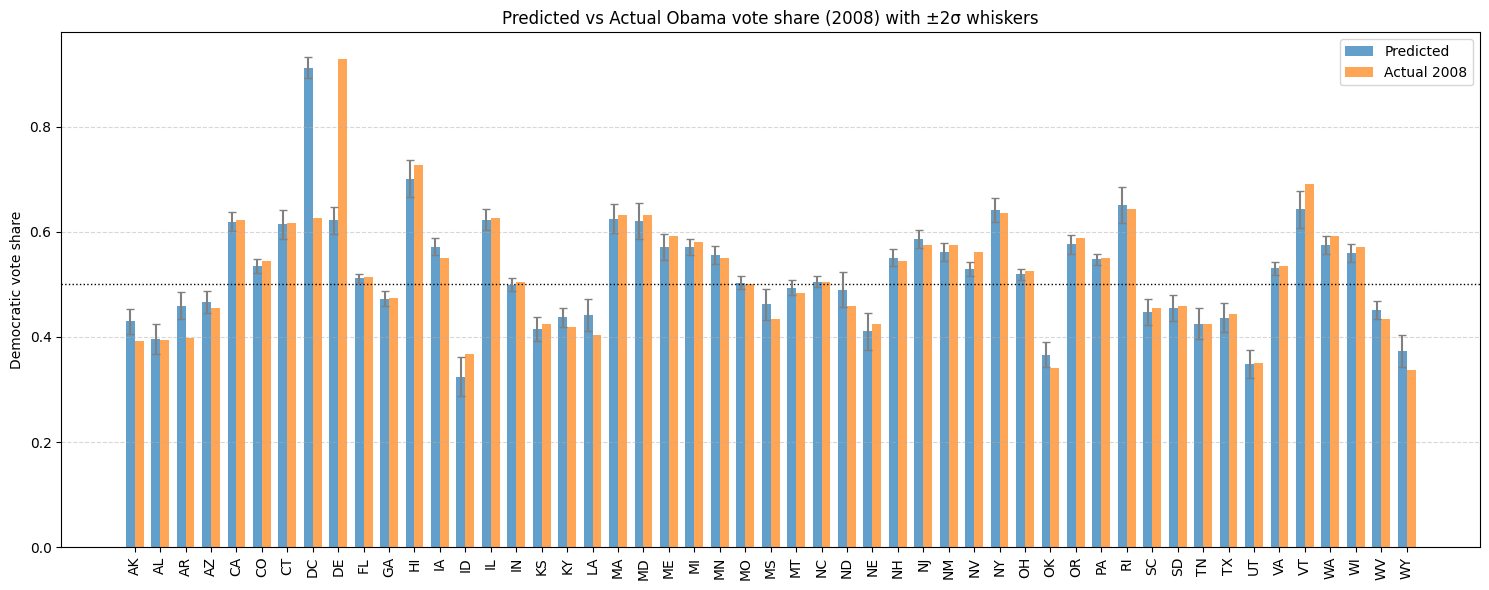

In [32]:

from cmdstanpy import CmdStanMCMC

# Load a previously saved output (assuming you saved with save_warmup=True)
# old_fit = CmdStanMCMC.from_csv('/content/drive/MyDrive/bayesian project/stan_output/poll_model-20250416154750_4.csv')

# 1) Extract posterior draws for the final day:
pi_samples = fit.stan_variable("pi")    # shape [draws, S, J]
final_draws = pi_samples[:, :, -1]      # shape [draws, S]

# 2) Compute mean and standard deviation for each state:
posterior_mean_final = final_draws.mean(axis=0)
posterior_sd_final   = final_draws.std(axis=0)

# 3) Load actual results and sort states as before:
results_2008 = pd.read_csv('data/2008.csv')
results_2008 = results_2008[results_2008['state'].isin(state_mapping)]
results_2008 = results_2008.sort_values('state')
actual_share = (results_2008['obama'] /
                (results_2008['obama'] + results_2008['mccain'])).values
states = sorted(state_mapping.keys())

# 4) Plot bars with grey ±2σ whiskers:
x = np.arange(len(states))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))

# drawing 0.5 win line
ax.axhline(0.5, color='black', linestyle=':', linewidth=1)


# Predicted bars with symmetric error = 2 * sd
ax.bar(
    x - width/2,
    posterior_mean_final,
    width,
    label='Predicted',
    yerr=2 * posterior_sd_final,  # ±2σ
    capsize=3,
    ecolor='grey',
    color='C0',
    alpha=0.7
)

# Actual bars
ax.bar(
    x + width/2,
    actual_share,
    width,
    label='Actual 2008',
    color='C1',
    alpha=0.7
)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)
ax.set_ylabel("Democratic vote share")
ax.set_title("Predicted vs Actual Obama vote share (2008) with ±2σ whiskers")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


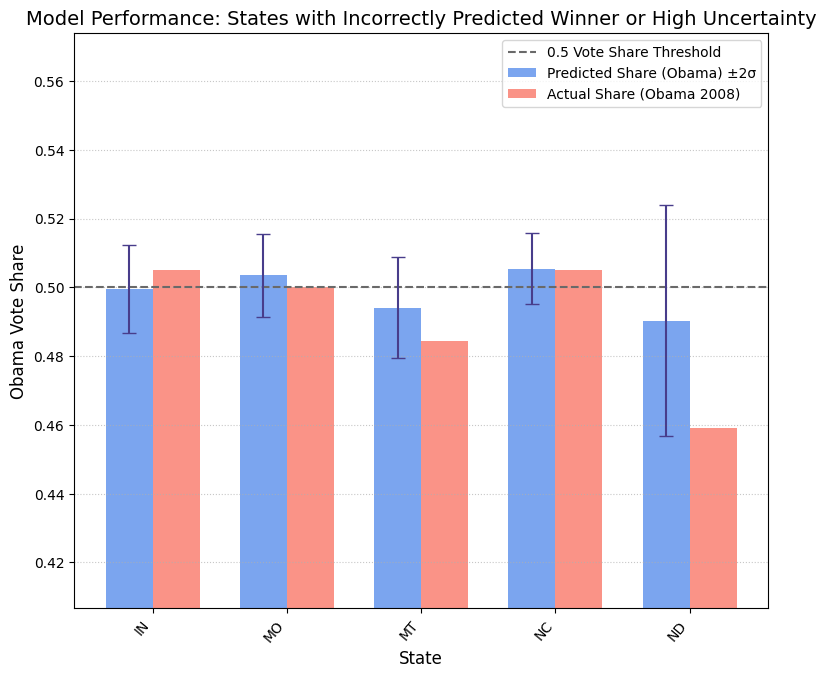

In [33]:
# --- Start of new cell code ---
# (Please ensure this code is placed in a new cell in your Jupyter notebook,
# and that the previous cells defining 'posterior_mean_final', 'posterior_sd_final',
# 'actual_share', and 'states' have been executed.)

import numpy as np
import matplotlib.pyplot as plt

# Filter states based on prediction performance
# Ensure all necessary variables from previous cells are available and correctly named:
# posterior_mean_final, posterior_sd_final, actual_share, states

# Condition 1: Incorrectly predicted winner
is_obama_win_predicted = posterior_mean_final > 0.5
is_obama_win_actual = actual_share > 0.5
incorrect_prediction_mask = (is_obama_win_predicted != is_obama_win_actual)

# Condition 2: Uncertainty covers both winning and losing case (0.5 threshold)
lower_bound_ci = posterior_mean_final - 2 * posterior_sd_final
upper_bound_ci = posterior_mean_final + 2 * posterior_sd_final
uncertain_prediction_mask = (lower_bound_ci < 0.5) & (upper_bound_ci > 0.5)

# Combine conditions: plot states that meet either condition
combined_mask = incorrect_prediction_mask | uncertain_prediction_mask
indices_of_interest = np.where(combined_mask)[0]

if len(indices_of_interest) == 0:
    print("No states met the criteria for this visualization: the model either correctly predicted the winner with sufficient certainty, or no misclassified states had uncertainty spanning the 0.5 threshold.")
else:
    states_to_plot = np.array(states)[indices_of_interest]
    means_to_plot = posterior_mean_final[indices_of_interest]
    sds_to_plot = posterior_sd_final[indices_of_interest]
    actuals_to_plot = actual_share[indices_of_interest]

    x_plot = np.arange(len(states_to_plot))
    bar_width = 0.35

    # Dynamically adjust figure size based on the number of states to plot
    fig_width = max(8, len(states_to_plot) * 0.9) # Min width 8, scale with 0.9 per state
    fig_height = 7 # Fixed height, can be adjusted

    fig_detailed, ax_detailed = plt.subplots(figsize=(fig_width, fig_height))

    # Draw the 0.5 vote share line for reference
    ax_detailed.axhline(0.5, color='dimgray', linestyle='--', linewidth=1.5, label='0.5 Vote Share Threshold')

    # Plot predicted vote shares with error bars
    ax_detailed.bar(
        x_plot - bar_width/2,
        means_to_plot,
        bar_width,
        label='Predicted Share (Obama) ±2σ',
        yerr=2 * sds_to_plot,
        capsize=5,
        ecolor='darkslateblue',
        color='cornflowerblue',
        alpha=0.85
    )

    # Plot actual vote shares
    ax_detailed.bar(
        x_plot + bar_width/2,
        actuals_to_plot,
        bar_width,
        label='Actual Share (Obama 2008)',
        color='salmon',
        alpha=0.85
    )

    # Set plot labels, title, and ticks
    ax_detailed.set_xticks(x_plot)
    ax_detailed.set_xticklabels(states_to_plot, rotation=50, ha="right", fontsize=10) # Adjusted rotation and font
    ax_detailed.set_ylabel("Obama Vote Share", fontsize=12)
    ax_detailed.set_xlabel("State", fontsize=12)
    ax_detailed.set_title("Model Performance: States with Incorrectly Predicted Winner or High Uncertainty", fontsize=14)

    # Dynamically adjust Y-axis limits for better visualization
    min_val_y_plot = 0.0
    max_val_y_plot = 1.0
    if len(states_to_plot) > 0: # Ensure there's data before calculating min/max
        min_val_y_plot = min(np.min(means_to_plot - 2*sds_to_plot), np.min(actuals_to_plot))
        max_val_y_plot = max(np.max(means_to_plot + 2*sds_to_plot), np.max(actuals_to_plot))

    # Add a small padding to y-limits, but keep them broadly within [0,1]
    ax_detailed.set_ylim(max(0, min_val_y_plot - 0.05), min(1.0, max_val_y_plot + 0.05))

    # Add legend
    handles, labels = ax_detailed.get_legend_handles_labels()
    if handles: # Only add legend if there are items to show
        ax_detailed.legend(handles, labels, loc='upper right', fontsize=10)

    # Add a grid for readability
    ax_detailed.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout(pad=1.5) # Added padding
    plt.show()
# --- End of new cell code ---

In [ ]:
# TODO: prior sensitivity analysis

## Kremp Model

### Create Kremp Model

In [134]:
kremp_stan_code = """
data {
  int<lower=1> K;
  int<lower=1> T;
  int<lower=1> S;
  int<lower=1> P; //Number of polls
  array[K] int<lower=1, upper=S> state;
  array[K] int<lower=1, upper=T> day;
  array[K] int<lower=1, upper=P> pollster;
  array[K] int<lower=0> n;
  array[K] int<lower=0> y;
  vector[S] h;
  matrix[S, S] Sigma_tau;
  matrix[S, S] Sigma_e;
  real<lower=0> sigma_u_upper_bound;
}
parameters {
  vector[T - 1] mu_a_raw;
  matrix[T, S] mu_b;
  vector[S] e;
  vector[K] u;
  vector[P] mu_c;
  real<lower=1e-6> sigma_a;
  real<lower=1e-6> sigma_b;
  real<lower=1e-6> sigma_c;
  real<lower=0> sigma_u;

}
transformed parameters {
  vector[T] mu_a;
  vector[S] mu_e;
  matrix[S, S] Sigma_mu_b;
  mu_a[T] = 0;
  for (s in 1:S)
    mu_e[s] = 0;
  for (t in 1:(T - 1))
    mu_a[t] = mu_a_raw[t];
}

model {
  for (p in 1:P){
    mu_c[p] ~ normal(0, sigma_c);
  }
  e ~ multi_normal(mu_e, Sigma_e);

  // Priors on beta (reverse random walk from election day J), using multinormal distribution
  mu_b[T] ~ multi_normal(logit(h), Sigma_tau);

  for (t in 1:(T - 1))
    mu_a[t] ~ normal(mu_a[t + 1], sigma_a);
  for (s in 1:S)
    for (t in 1:(T - 1))
      mu_b[t, s] ~ normal(mu_b[t + 1, s], sigma_b);
    
  // measurement error
  for (k in 1:K)
    u[k] ~ normal(0, sigma_u);

  // Likelihood: poll observations
  for (k in 1:K) {
    // add up components
    real logit_pi = mu_a[day[k]] + mu_b[day[k], state[k]] + mu_c[pollster[k]] + e[state[k]] + u[k];
    // Define the vote share as the logit of the probability of Dem winning
    y[k] ~ binomial_logit(n[k], logit_pi);
  }

  // Hyper-priors
  sigma_a ~ normal(0,0.5);   // half-normal
  sigma_b ~ normal(0,0.5);   // half-normal
  sigma_c ~ normal(0,0.5);   // half-normal
  sigma_u ~ normal(0,sigma_u_upper_bound);

}

generated quantities {
  matrix[S, T] pi;
  for (s in 1:S)
    for (t in 1:T)
      pi[s, t] = inv_logit(mu_b[t, s]+mu_a[t]);
}
"""

with open("model/kremp_2008_model.stan", "w") as f:
    f.write(kremp_stan_code)

In [135]:
# --- Kremp Data ---
# Drop national-level entries (if any)
kremp_df = df[df['state'] != '--'].copy()

# Create 1-indexed state and pollster mappings
state_mapping_kremp = {state: i + 1 for i, state in enumerate(sorted(kremp_df['state'].unique()))}
pollster_mapping_kremp = {pollster: i + 1 for i, pollster in enumerate(sorted(kremp_df['pollster'].unique()))}

# Apply mappings
kremp_df['index_s'] = kremp_df['state'].map(state_mapping_kremp)
kremp_df['index_p'] = kremp_df['pollster'].map(pollster_mapping_kremp)
kremp_df['index_t'] = (kremp_df['t'] - kremp_df['t'].min()).dt.days + 1

# Ensure full index range for Stan input
K_kremp = len(kremp_df)
S_kremp = len(state_mapping_kremp)
T_kremp = kremp_df['index_t'].max()
P_kremp = len(pollster_mapping_kremp)

# Same priors as Linzer model
h_kremp = state_results_2004.sort_values('state')['h_prior'].values[:S_kremp]

# ---------------------------------------------------------------------------
# Σ_τ  :  diag = 1/20  ,  off-diag = 1/40
# Σ_e  :  diag = (0.04)**2 , off-diag = 0.00175
# ---------------------------------------------------------------------------

diag_tau   = 1.0 / 20.0          # 0.05
off_tau    = 1.0 / 40.0          # 0.025

var_e_diag = 0.04 ** 2           # 0.0016
corr_coeff = 0.7
off_e      = var_e_diag*corr_coeff

Sigma_tau_kremp = np.full((S_kremp, S_kremp), off_tau, dtype=float)
np.fill_diagonal(Sigma_tau_kremp, diag_tau)

Sigma_e_kremp   = np.full((S_kremp, S_kremp), off_e, dtype=float)
np.fill_diagonal(Sigma_e_kremp, var_e_diag)

sigma_u_upper_bound = 0.2

# ---------------------------------------------------------------------------
kremp_data = {
    "K": K_kremp,
    "T": T_kremp,
    "S": S_kremp,
    "P": P_kremp,
    "state":   kremp_df["index_s"].astype(int).tolist(),
    "day":     kremp_df["index_t"].astype(int).tolist(),
    "pollster":kremp_df["index_p"].astype(int).tolist(),
    "n": (kremp_df["n_obama"] + kremp_df["n_mccain"]).astype(int).tolist(),
    "y": kremp_df["n_obama"].astype(int).tolist(),
    "h": h_kremp.tolist(),
    "Sigma_tau": Sigma_tau_kremp.tolist(),
    "Sigma_e":   Sigma_e_kremp.tolist(),
    "sigma_u_upper_bound": sigma_u_upper_bound
}


### Fit Kremp Model

In [136]:
# Compile model
kremp_model = CmdStanModel(stan_file="model/kremp_2008_model.stan")
kremp_fit = kremp_model.sample(data=kremp_data, chains=4, iter_sampling=500, iter_warmup=500, show_console=True)
kremp_pi = np.mean(kremp_fit.stan_variable("pi"), axis=0)

python(32064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
13:31:50 - cmdstanpy - INFO - compiling stan file /Users/maxtan/Documents/MIT/Spring_2025/bayesian_modeling/project/code/model/poll_model_kremp.stan to exe file /Users/maxtan/Documents/MIT/Spring_2025/bayesian_modeling/project/code/model/poll_model_kremp
python(32066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
13:32:07 - cmdstanpy - INFO - compiled model executable: /Users/maxtan/Documents/MIT/Spring_2025/bayesian_modeling/project/code/model/poll_model_kremp
python(32186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
13:32:07 - cmdstanpy - INFO - Chain [1] start processing
13:32:07 - cmdstanpy - INFO - Chain [2] start processing
13:32:07 - cmdstanpy - INFO - Chain [3] start processing
python(32189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
13:32:07 - cmdstanpy - INFO - C

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 500
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/15/mymz4pp57vl23l_yjdgq0xvh0000gn/T/tmp6p_199sc/4ea_8geb.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [

13:42:27 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 338.247 seconds (Warm-up)
Chain [1] 280.967 seconds (Sampling)
Chain [1] 619.214 seconds (Total)
Chain [1] 
Chain [1] 
Chain [3] Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain [4] Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)


13:42:51 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 347.173 seconds (Warm-up)
Chain [2] 296.468 seconds (Sampling)
Chain [2] 643.641 seconds (Total)
Chain [2] 
Chain [2] 
Chain [3] Iteration: 1000 / 1000 [100%]  (Sampling)


13:43:51 - cmdstanpy - INFO - Chain [3] done processing


Chain [3] 
Chain [3] Elapsed Time: 354.157 seconds (Warm-up)
Chain [3] 349.108 seconds (Sampling)
Chain [3] 703.265 seconds (Total)
Chain [3] 
Chain [3] 
Chain [4] Iteration: 1000 / 1000 [100%]  (Sampling)


13:43:55 - cmdstanpy - INFO - Chain [4] done processing
13:43:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', line 57, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', line 57, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', line 57, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', line 57, column 4 to column 30)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', line 57, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', line 57, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'poll_model_kremp.stan', li

Chain [4] 
Chain [4] Elapsed Time: 360.033 seconds (Warm-up)
Chain [4] 347.35 seconds (Sampling)
Chain [4] 707.383 seconds (Total)
Chain [4] 
Chain [4] 


13:43:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 271 iterations at max treedepth (54.2%)
	Chain 2 had 329 iterations at max treedepth (65.8%)
	Chain 3 had 489 iterations at max treedepth (97.8%)
	Chain 4 had 496 iterations at max treedepth (99.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [137]:
description = "kremp_model"
# local
os.makedirs('stan_output/', exist_ok = True)

kremp_fit.save_csvfiles(dir=f"stan_output/{description}/")
summary_df = kremp_fit.summary()
summary_df.to_csv(f"stan_output/{description}/fit_summary.csv")

python(32550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Plot Results

#### Time Series Plot

Plotting for Florida (FL)
Plot for FL saved to FL_election_forecast_plot.png


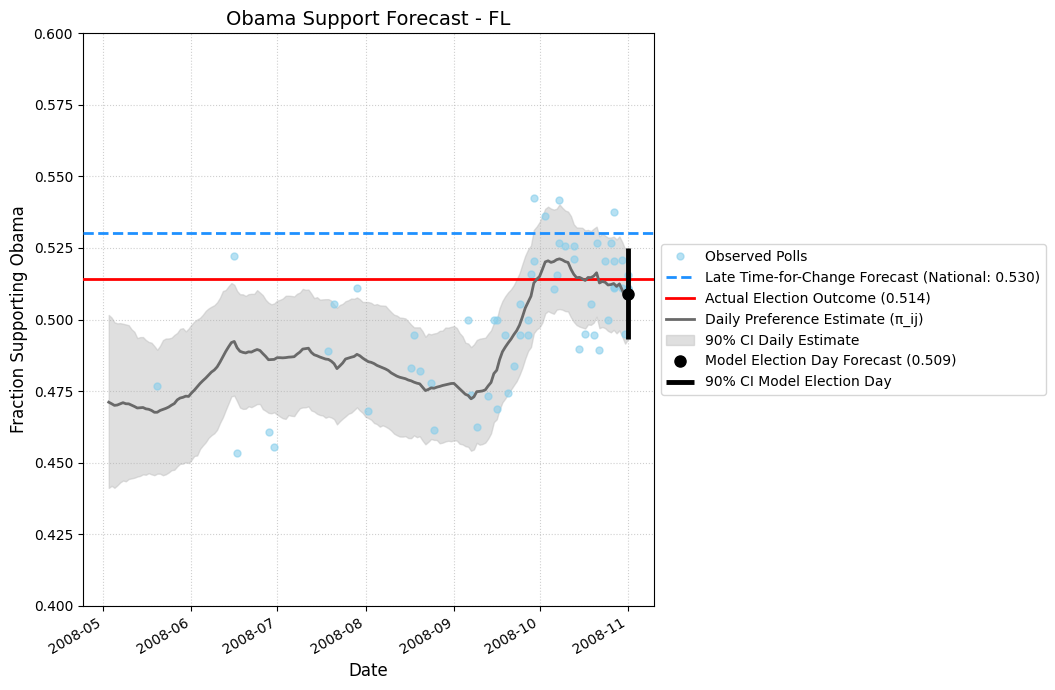

\nPlotting for Indiana (IN)
Plot for IN saved to IN_election_forecast_plot.png


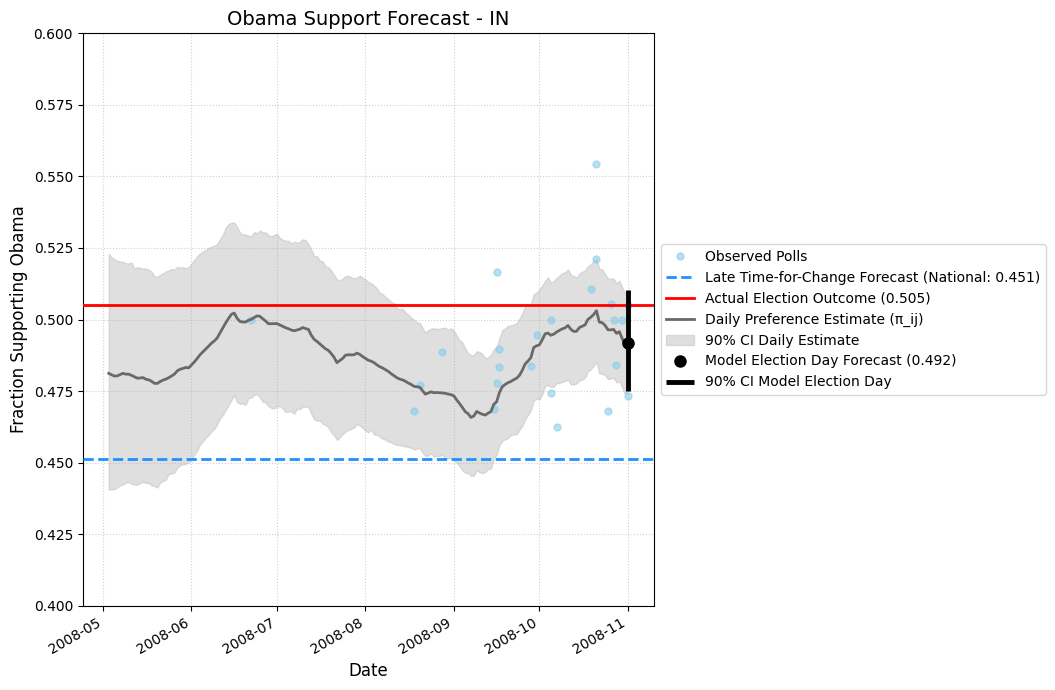

In [138]:
print("Plotting for Florida (FL)")

day_objects_kremp = pd.to_datetime([start_date + pd.Timedelta(days=i) for i in range(J)]) # From cell 13 for model_linzner_stan

plot_state_election_forecast_from_notebook_data(
    state_abbr='FL', 
    fit_model=kremp_fit,  # This should be your actual CmdStanMCMC object
    loaded_state_mapping=state_mapping, 
    polls_df=kremp_df, 
    model_dates_array=day_objects_linzner, 
    current_election_day=election_day
)

print("\\nPlotting for Indiana (IN)")
plot_state_election_forecast_from_notebook_data(
    state_abbr='IN', 
    fit_model=kremp_fit, 
    loaded_state_mapping=state_mapping, 
    polls_df=kremp_df, 
    model_dates_array=day_objects_linzner, 
    current_election_day=election_day
)

#### Outcomes

17:04:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 500 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
17:04:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 496 iterations at max treedepth (99.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


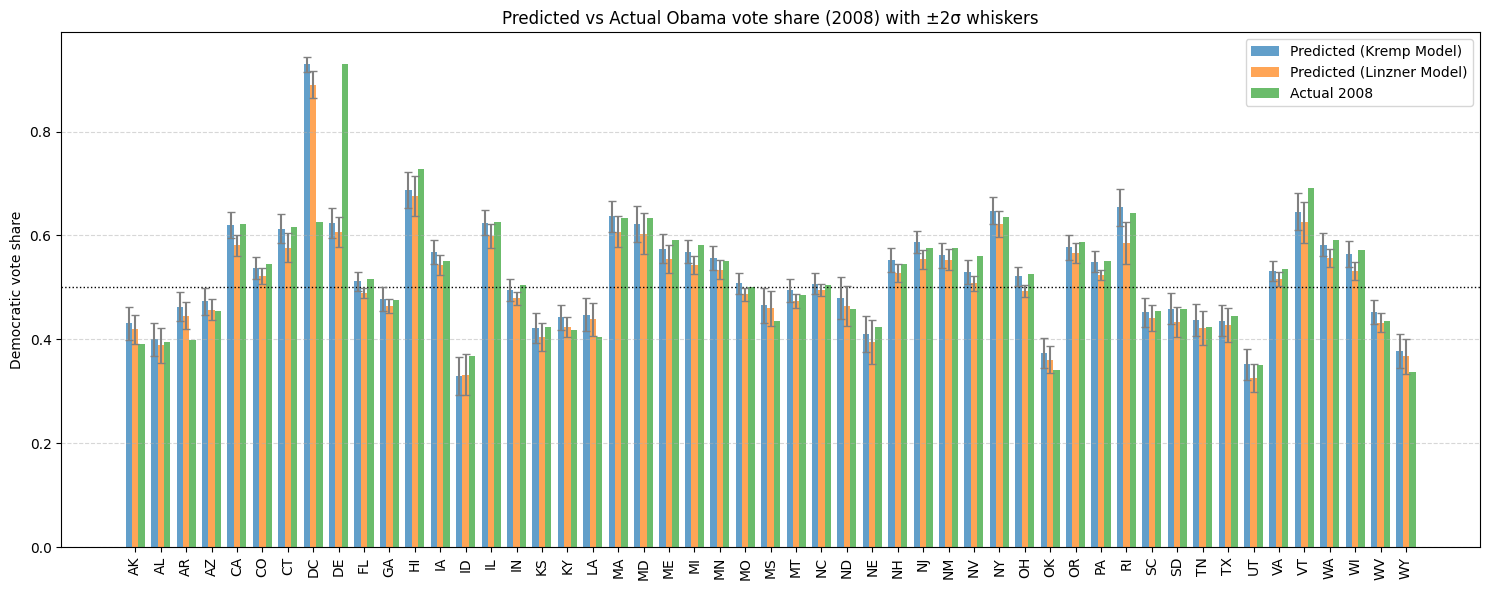

<Figure size 640x480 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cmdstanpy import from_csv

fit = from_csv('stan_output/first_run_max/linzner_2008_model-20250506141115_4.csv')
kremp_fit = from_csv('stan_output/kremp_model/poll_model_kremp-20250509133207_4.csv')

# Load a previously saved output (assuming you saved with save_warmup=True)
# old_fit = CmdStanMCMC.from_csv('/content/drive/MyDrive/bayesian project/stan_output/poll_model-20250416154750_4.csv')

# 1) Extract posterior draws for the final day:
pi_samples_kremp = kremp_fit.stan_variable("pi")    # shape [draws, S, J]
final_draws_kremp = pi_samples_kremp[:, :, -1]      # shape [draws, S]

# posterior from fit
pi_samples_linzner = fit.stan_variable("pi")    # shape [draws, S, J]
final_draws_linzner = pi_samples_linzner[:, :, -1]      # shape [draws, S]

# 2) Compute mean and standard deviation for each state:
posterior_mean_final_kremp = final_draws_kremp.mean(axis=0)
posterior_sd_final_kremp = final_draws_kremp.std(axis=0)

posterior_mean_final_linzner = final_draws_linzner.mean(axis=0)
posterior_sd_final_linzner  = final_draws_linzner.std(axis=0)


# 3) Load actual results and sort states as before:
results_2008 = pd.read_csv('data/2008.csv')
results_2008 = results_2008[results_2008['state'].isin(state_mapping)]
results_2008 = results_2008.sort_values('state')
actual_share = (results_2008['obama'] /
                (results_2008['obama'] + results_2008['mccain'])).values
states = sorted(state_mapping.keys())[1:]

# 4) Plot bars with grey ±2σ whiskers:
x = np.arange(len(states))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 6))

# drawing 0.5 win line
ax.axhline(0.5, color='black', linestyle=':', linewidth=1)


# Predicted bars with symmetric error = 2 * sd
ax.bar(
    x - width,
    posterior_mean_final_kremp,
    width,
    label='Predicted (Kremp Model)',
    yerr=2 * posterior_sd_final_kremp,  # ±2σ
    capsize=3,
    ecolor='grey',
    color='C0',
    alpha=0.7
)

ax.bar(
    x,
    posterior_mean_final_linzner,
    width,
    label='Predicted (Linzner Model)',
    yerr=2 * posterior_sd_final_linzner,  # ±2σ
    capsize=3,
    ecolor='grey',
    color='C1',
    alpha=0.7
)

# Actual bars
ax.bar(
    x + width,
    actual_share,
    width,
    label='Actual 2008',
    color='C2',
    alpha=0.7
)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)
ax.set_ylabel("Democratic vote share")
ax.set_title("Predicted vs Actual Obama vote share (2008) with ±2σ whiskers")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.savefig('figures/linzner_kremp_2008_comparison_all_states.png')


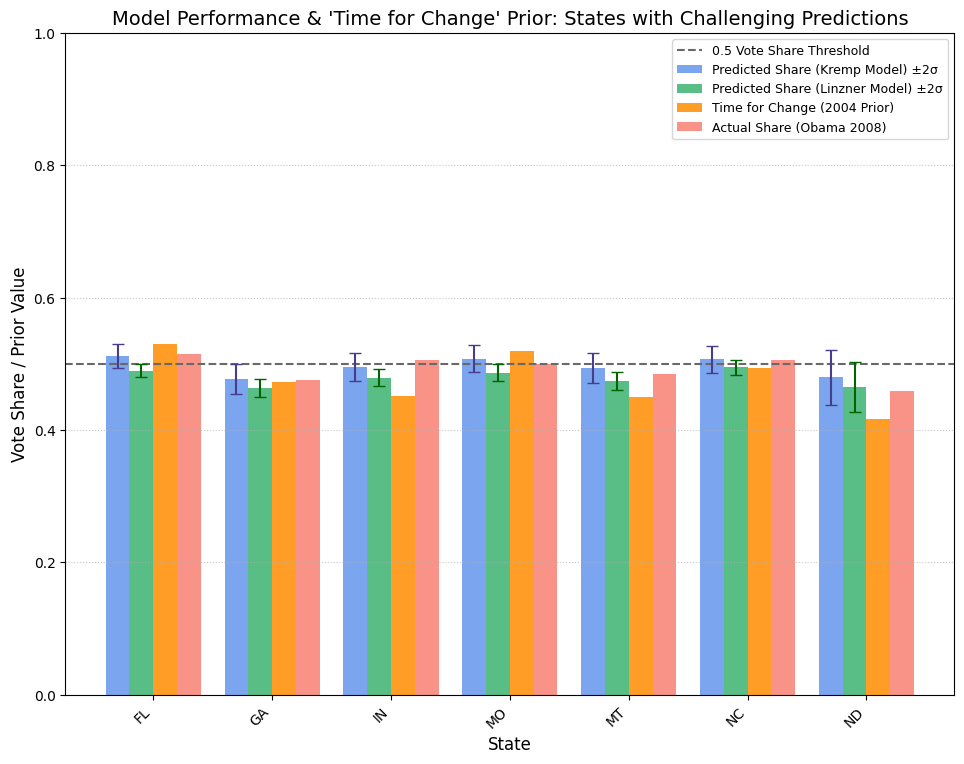

<Figure size 640x480 with 0 Axes>

In [32]:
# --- Start of new cell code ---
# (Please ensure this code is placed in a new cell in your Jupyter notebook,
# and that the previous cells defining 'posterior_mean_final_kremp', 'posterior_sd_final_kremp',
# 'posterior_mean_final_linzner', 'posterior_sd_final_linzner', 
# 'actual_share', 'states', and 'state_results_2004' have been executed.)

import numpy as np
import matplotlib.pyplot as plt

# Ensure all necessary variables from previous cells are available and correctly named:
# posterior_mean_final_kremp, posterior_sd_final_kremp, 
# posterior_mean_final_linzner, posterior_sd_final_linzner,
# actual_share, states, state_results_2004

# Condition 1: Incorrectly predicted winner (using Kremp model as the primary for this condition)
is_obama_win_predicted_kremp = posterior_mean_final_kremp > 0.5
is_obama_win_actual = actual_share > 0.5
incorrect_prediction_mask = (is_obama_win_predicted_kremp != is_obama_win_actual)

# Condition 2: Uncertainty covers both winning and losing case (0.5 threshold, using Kremp model)
lower_bound_ci_kremp = posterior_mean_final_kremp - 2 * posterior_sd_final_kremp
upper_bound_ci_kremp = posterior_mean_final_kremp + 2 * posterior_sd_final_kremp
uncertain_prediction_mask = (lower_bound_ci_kremp < 0.5) & (upper_bound_ci_kremp > 0.5)

# Combine conditions: plot states that meet either condition
combined_mask = incorrect_prediction_mask | uncertain_prediction_mask
indices_of_interest = np.where(combined_mask)[0]

if len(indices_of_interest) == 0:
    print("No states met the criteria for this visualization: the model either correctly predicted the winner with sufficient certainty, or no misclassified states had uncertainty spanning the 0.5 threshold.")
else:
    states_to_plot = np.array(states)[indices_of_interest]
    means_to_plot_kremp = posterior_mean_final_kremp[indices_of_interest]
    sds_to_plot_kremp = posterior_sd_final_kremp[indices_of_interest]
    means_to_plot_linzner = posterior_mean_final_linzner[indices_of_interest]
    sds_to_plot_linzner = posterior_sd_final_linzner[indices_of_interest]
    actuals_to_plot = actual_share[indices_of_interest]
    
    # Ensure state_results_2004['h_prior'] is numpy array and can be indexed by indices_of_interest
    # If it's a pandas Series aligned with 'states', this direct indexing might work if 'states' is an index.
    # If 'states' is a list of names, you might need to align/filter state_results_2004['h_prior'] first.
    # For robustness, assuming state_results_2004['h_prior'] is a NumPy array aligned with the original 'states' array:
    h_prior_full = np.array(state_results_2004['h_prior']) 
    h_prior_to_plot = h_prior_full[indices_of_interest]

    x_plot = np.arange(len(states_to_plot))
    bar_width = 0.20 # Adjusted bar width to fit four bars more comfortably

    # Dynamically adjust figure size based on the number of states to plot
    fig_width = max(10, len(states_to_plot) * 1.2) # Adjusted for more bars
    fig_height = 8 # Adjusted for potentially wider legend/more bars

    fig_detailed, ax_detailed = plt.subplots(figsize=(fig_width, fig_height))

    # Draw the 0.5 vote share line for reference
    ax_detailed.axhline(0.5, color='dimgray', linestyle='--', linewidth=1.5, label='0.5 Vote Share Threshold')

    # Plot predicted vote shares (Kremp Model)
    ax_detailed.bar(
        x_plot - 1.5 * bar_width, 
        means_to_plot_kremp,
        bar_width,
        label='Predicted Share (Kremp Model) ±2σ',
        yerr=2 * sds_to_plot_kremp,
        capsize=4, # Adjusted capsize
        ecolor='darkslateblue',
        color='cornflowerblue',
        alpha=0.85
    )

    # Plot predicted vote shares (Linzner Model)
    ax_detailed.bar(
        x_plot - 0.5 * bar_width,
        means_to_plot_linzner,
        bar_width,
        label='Predicted Share (Linzner Model) ±2σ',
        yerr=2 * sds_to_plot_linzner,
        capsize=4, # Adjusted capsize
        ecolor='darkgreen', # Different ecolor for distinction
        color='mediumseagreen',
        alpha=0.85
    )

    # Plot "Time for Change" (h_prior)
    ax_detailed.bar(
        x_plot + 0.5 * bar_width,
        h_prior_to_plot,
        bar_width,
        label='Time for Change (2004 Prior)', # Updated label
        color='darkorange', 
        alpha=0.85
    )

    # Plot actual vote shares
    ax_detailed.bar(
        x_plot + 1.5 * bar_width,
        actuals_to_plot,
        bar_width,
        label='Actual Share (Obama 2008)',
        color='salmon',
        alpha=0.85
    )

    # Set plot labels, title, and ticks
    ax_detailed.set_xticks(x_plot)
    ax_detailed.set_xticklabels(states_to_plot, rotation=45, ha="right", fontsize=10) # Adjusted rotation
    ax_detailed.set_ylabel("Vote Share / Prior Value", fontsize=12) # Generalized Y-axis label
    ax_detailed.set_xlabel("State", fontsize=12)
    ax_detailed.set_title("Model Performance & 'Time for Change' Prior: States with Challenging Predictions", fontsize=14) # Updated title

    # Dynamically adjust Y-axis limits for better visualization
    if len(states_to_plot) > 0:
        all_series_min = [
            np.min(means_to_plot_kremp - 2 * sds_to_plot_kremp),
            np.min(means_to_plot_linzner - 2 * sds_to_plot_linzner),
            np.min(actuals_to_plot),
            np.min(h_prior_to_plot)
        ]
        all_series_max = [
            np.max(means_to_plot_kremp + 2 * sds_to_plot_kremp),
            np.max(means_to_plot_linzner + 2 * sds_to_plot_linzner),
            np.max(actuals_to_plot),
            np.max(h_prior_to_plot)
        ]
        min_val_y_plot = np.min(all_series_min)
        max_val_y_plot = np.max(all_series_max)
        
        # Add a small padding to y-limits
        y_padding = (max_val_y_plot - min_val_y_plot) * 0.05 # 5% padding
        y_lower_limit = min_val_y_plot - y_padding
        y_upper_limit = max_val_y_plot + y_padding

        # Ensure 0 and 1 are within view if data is vote share like, but allow expansion
        ax_detailed.set_ylim(min(y_lower_limit, 0 if min_val_y_plot >=0 else y_lower_limit), 
                             max(y_upper_limit, 1 if max_val_y_plot <=1 else y_upper_limit) )
    else: # Default if no states to plot
        ax_detailed.set_ylim(0, 1)


    # Add legend
    handles, labels = ax_detailed.get_legend_handles_labels()
    if handles: 
        ax_detailed.legend(handles, labels, loc='upper right', fontsize=9) # Adjusted fontsize

    # Add a grid for readability
    ax_detailed.grid(True, axis='y', linestyle=':', alpha=0.7)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout(pad=2.0) # Increased padding slightly
    plt.show()
    plt.savefig('figures/linzner_kremp_2008_comparison_close_states.png')
# --- End of new cell code ---